# Transfer Learning with Pretrained Models (ResNet50)

In this notebook, we’ll explore **Transfer Learning** — a powerful Deep Learning technique that allows us to leverage **pre-trained models** to solve new tasks efficiently.

### Objectives
- Understand what transfer learning is and why it’s useful.
- Learn how to use a pre-trained model (ResNet50) from Keras.
- Fine-tune the model for a custom classification problem.
- Evaluate model performance.

---

### Transfer Learning

Transfer Learning means **reusing a pre-trained model** that has learned rich feature representations from a large dataset (like ImageNet) and adapting it to a new but related task.

For example:
- Base Model: ResNet50 trained on ImageNet (1,000 classes)
- New Task: Classify cats vs dogs or flowers
- We reuse early layers (edge, texture detection) and retrain only top layers.


In [32]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os


## Step 1: Dataset Preparation

We’ll use a **sample dataset** — for example, the "cats_vs_dogs" dataset from TensorFlow Datasets.

The data will be split into:
- Training Set (80%)
- Validation Set (20%)

We will:
1. Load and preprocess images.
2. Resize them to match the model input (224x224 for ResNet50).
3. Apply normalization and data augmentation to improve generalization.


In [45]:
# Download dataset from TensorFlow storage
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# Download and extract the dataset
dataset_path = tf.keras.utils.get_file(
    "cats_and_dogs_filtered.zip",
    origin=dataset_url,
    extract=True
)

# Build correct folder paths
base_dir = os.path.join(os.path.dirname(dataset_path), "cats_and_dogs_filtered_extracted","cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Step 2: Load the Pretrained Model (ResNet50)

We will use **ResNet50** trained on **ImageNet**:
- Exclude the top classification layer (`include_top=False`)
- Set `weights='imagenet'`
- Freeze base layers so they are not retrained initially


In [47]:
# Load ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Step 3: Build Custom Classification Layers

We'll add:
- **Global Average Pooling**: reduces spatial dimensions
- **Dropout Layer**: prevents overfitting
- **Dense Layer**: outputs final class probabilities


In [48]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Step 4: Compile the Model

We'll use:
- **Binary Crossentropy** loss (since cats vs dogs is a binary classification task)
- **Adam Optimizer** with learning rate 0.0001
- **Accuracy** metric for evaluation


In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Step 5: Train the Model

We’ll train only the **newly added layers** for now (base layers frozen).

Later, we’ll **unfreeze** a few layers and fine-tune.


In [50]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_generator
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.6635 - loss: 0.6429 - val_accuracy: 0.5000 - val_loss: 0.8771
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.8135 - loss: 0.4241 - val_accuracy: 0.5000 - val_loss: 0.9349
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.8705 - loss: 0.3173 - val_accuracy: 0.5000 - val_loss: 0.9676
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.9160 - loss: 0.2430 - val_accuracy: 0.5000 - val_loss: 1.0129
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.9275 - loss: 0.2077 - val_accuracy: 0.5000 - val_loss: 1.0333


## Step 6: Fine-Tuning the Model

After initial training, we’ll unfreeze the top few layers of ResNet50 and train again with a smaller learning rate.

This helps adapt pre-trained features to our specific dataset.


In [51]:
# Unfreeze top 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_ds,
    epochs=3,
    validation_data=val_ds
)


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.9445 - loss: 0.1763 - val_accuracy: 0.9710 - val_loss: 0.0912
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.9680 - loss: 0.1128 - val_accuracy: 0.9780 - val_loss: 0.0686
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9805 - loss: 0.0787 - val_accuracy: 0.9790 - val_loss: 0.0597


## Step 7: Evaluate and Visualize Results

We’ll now check how well our fine-tuned model performs.
We'll also plot training curves to visualize accuracy and loss.


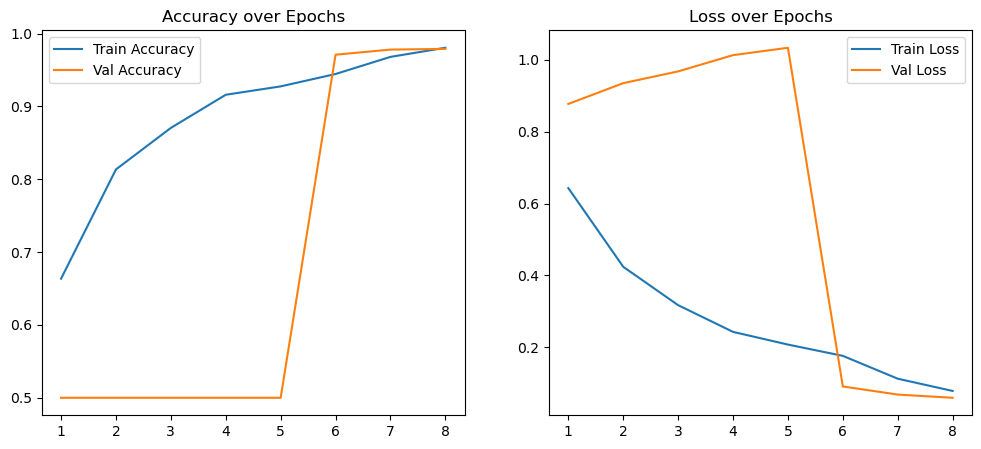

In [52]:
# Combine both histories
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()


## Step 8: Save the Model

Finally, we save our fine-tuned model for later use.


In [ ]:
model.save("resnet50_transfer_learning.h5")
print("✅ Model saved successfully!")


## Summary

In this notebook, we learned how to:
1. Load and preprocess a dataset.
2. Use a pre-trained model (ResNet50).
3. Freeze and fine-tune layers.
4. Train and evaluate the transfer learning model.
5. Save the trained model for deployment.

---

### Key Takeaways
- Transfer Learning reduces training time and improves performance with limited data.
- Start with frozen layers, then fine-tune top layers.
- Use small learning rates during fine-tuning.

You can adapt this notebook for **multi-class classification**, **different architectures (VGG16, InceptionV3)**, or **custom datasets**.
